Note: you may need to restart the kernel to use updated packages.
Loading data...
Loaded 7951 common hours for 10 assets.


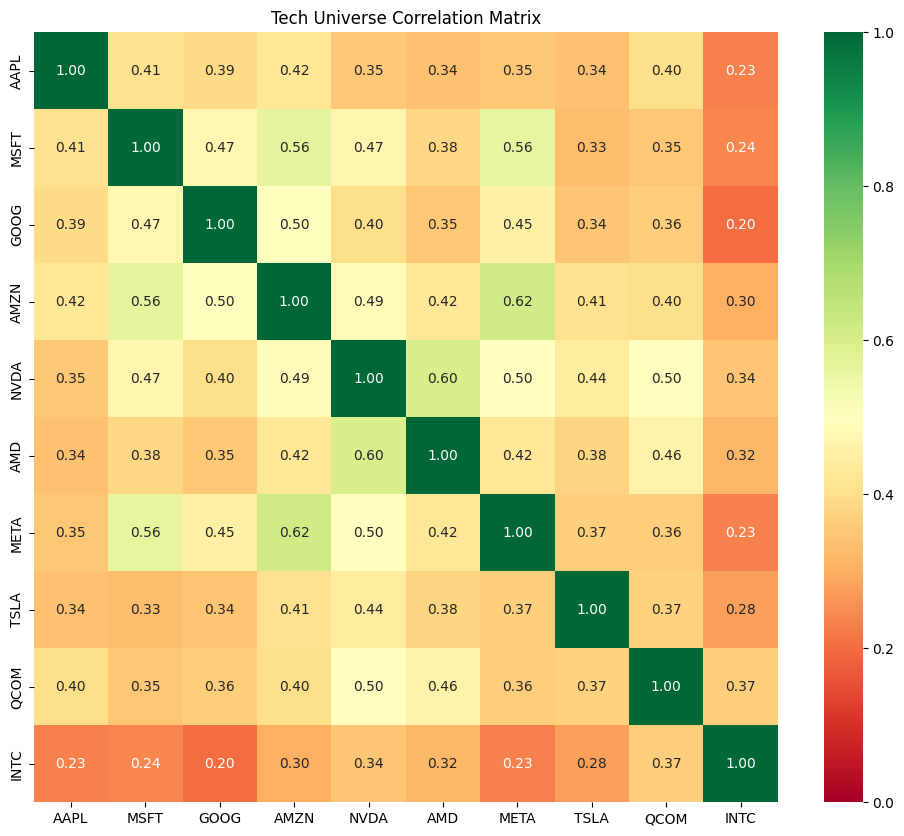

In [3]:
import arcticdb as adb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the "Vault"
# Inside Docker, this points to your newly renamed 'data' folder
store = adb.Arctic("lmdb:///app/data")
lib = store["quant_data_v1"]

# The Universe
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'AMD', 'META', 'TSLA', 'QCOM', 'INTC']

# Load Prices
data_dict = {}
print("Loading data...")
for t in tickers:
    if lib.has_symbol(t):
        # We only need the 'close' column for correlation
        df = lib.read(t).data
        data_dict[t] = df['close']

# Align timestamps (drop rows where any stock is missing data)
prices = pd.DataFrame(data_dict).dropna()
print(f"Loaded {len(prices)} common hours for {len(prices.columns)} assets.")

# Calculate Correlations
returns = prices.pct_change().dropna()
corr_matrix = returns.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f", vmin=0, vmax=1)
plt.title("Tech Universe Correlation Matrix")
plt.show()

Hedge Ratio: 0.3488
Interpretation: For every 1 share of NVDA, we sell 0.35 shares of AMD.

--- Cointegration Test Results ---
ADF Statistic: -1.9212
P-Value: 0.3222


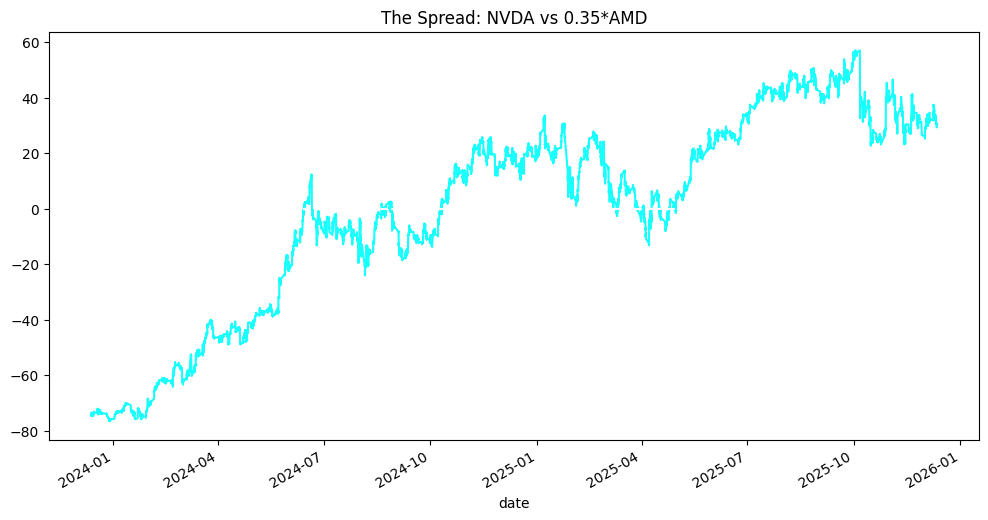

❌ VERDICT: FAILED. The spread is a Random Walk. Do not trade.


In [6]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# 1. Define the Pair
s1 = prices['NVDA']  # The Target
s2 = prices['AMD']   # The Hedge

# 2. Calculate the Hedge Ratio (Linear Regression)
# We find the 'Beta' that makes the spread flat.
s2 = sm.add_constant(s2)
model = sm.OLS(s1, s2).fit()
hedge_ratio = model.params['AMD']
print(f"Hedge Ratio: {hedge_ratio:.4f}")
print(f"Interpretation: For every 1 share of NVDA, we sell {hedge_ratio:.2f} shares of AMD.")

# 3. Construct the Spread
# Spread = NVDA - (Beta * AMD) - Alpha
spread = s1 - model.predict(s2)

# 4. The "Rubber Band" Test (Augmented Dickey-Fuller)
# Null Hypothesis: The spread is drifting away (Random Walk).
# Alternative Hypothesis: The spread is Mean Reverting (Stationary).
adf = adfuller(spread)

print(f"\n--- Cointegration Test Results ---")
print(f"ADF Statistic: {adf[0]:.4f}")
print(f"P-Value: {adf[1]:.4f}")

# 5. Visualize the Spread
plt.figure(figsize=(12, 6))
spread.plot(color='cyan', alpha=0.9)
plt.axhline(spread.mean(), color='white', linestyle='--')
plt.title(f"The Spread: NVDA vs {hedge_ratio:.2f}*AMD")
plt.style.use('dark_background')
plt.show()

# verdict
if adf[1] < 0.05:
    print("✅ VERDICT: PASSED. The pair is Cointegrated. Proceed to Strategy.")
else:
    print("❌ VERDICT: FAILED. The spread is a Random Walk. Do not trade.")

Scanning Universe for Cointegration...

--- SCAN COMPLETE ---
Total Pairs Tested: 90
Passing Pairs (P-Value < 0.05): 8

🏆 TOP 5 COINTEGRATED PAIRS 🏆
         Pair  Hedge_Ratio   P_Value  Stationary
54  AMZN-TSLA     0.229727  0.002357        True
53  META-AMZN     3.901052  0.014284        True
48  AMZN-NVDA     0.571380  0.015415        True
52  AMZN-META     0.197950  0.016325        True
55  TSLA-AMZN     3.048900  0.024894        True
64  NVDA-TSLA     0.318656  0.040070        True
49  NVDA-AMZN     1.329633  0.040981        True
78  META-TSLA     0.879006  0.048388        True

Visualizing Winner: AMZN-TSLA


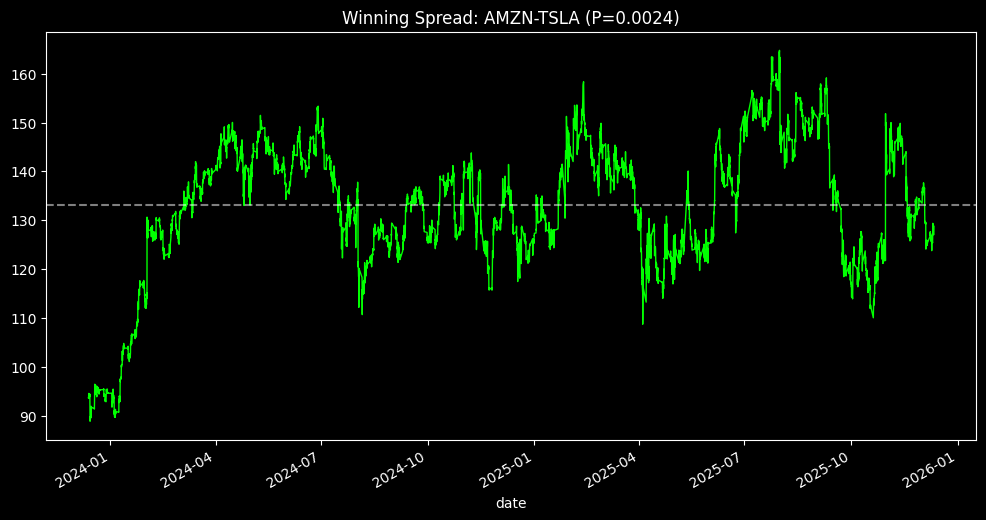

In [7]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

# 1. Setup
pairs_results = []
print("Scanning Universe for Cointegration...")

# 2. The Systematic Loop
# We check every unique combination (e.g., AAPL/MSFT, AAPL/GOOG...)
for asset_a, asset_b in combinations(prices.columns, 2):
    
    # Get Price Series
    s1 = prices[asset_a]
    s2 = prices[asset_b]
    
    # Run OLS (Hedge Ratio)
    # We try both directions: A = Beta*B  AND  B = Beta*A
    # Because sometimes one is the leader and one is the follower.
    for y, x, label in [(s1, s2, f"{asset_a}-{asset_b}"), (s2, s1, f"{asset_b}-{asset_a}")]:
        
        x_const = sm.add_constant(x)
        model = sm.OLS(y, x_const).fit()
        hedge_ratio = model.params.iloc[1]
        
        # Calculate Spread
        spread = y - model.predict(x_const)
        
        # Run ADF Test
        adf_result = adfuller(spread)
        p_value = adf_result[1]
        
        # Store Data
        pairs_results.append({
            'Pair': label,
            'Hedge_Ratio': hedge_ratio,
            'P_Value': p_value,
            'Stationary': p_value < 0.05
        })

# 3. The Leaderboard
results_df = pd.DataFrame(pairs_results)
passed_pairs = results_df[results_df['Stationary'] == True].sort_values('P_Value')

print(f"\n--- SCAN COMPLETE ---")
print(f"Total Pairs Tested: {len(results_df)}")
print(f"Passing Pairs (P-Value < 0.05): {len(passed_pairs)}")

print("\n🏆 TOP 5 COINTEGRATED PAIRS 🏆")
print(passed_pairs.head(10))

# 4. Visualization of the Winner
if not passed_pairs.empty:
    best_pair = passed_pairs.iloc[0]
    print(f"\nVisualizing Winner: {best_pair['Pair']}")
    
    # Reconstruct the winning spread
    assets = best_pair['Pair'].split('-')
    y = prices[assets[0]]
    x = prices[assets[1]]
    spread = y - (best_pair['Hedge_Ratio'] * x)
    
    plt.figure(figsize=(12, 6))
    spread.plot(color='#00ff00', linewidth=1)
    plt.axhline(spread.mean(), color='white', linestyle='--', alpha=0.5)
    plt.title(f"Winning Spread: {best_pair['Pair']} (P={best_pair['P_Value']:.4f})")
    plt.style.use('dark_background')
    plt.show()
else:
    print("⚠️ No pairs passed the test. We need a larger universe or higher frequency data.")

In [3]:
import arcticdb as adb
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

print("--- SECTOR ARBITRAGE: MSFT vs QQQ ---")

# 1. Load Data
store = adb.Arctic("lmdb:///app/data")
lib = store["quant_data_v1"]
msft = lib.read("MSFT").data['close']
qqq = lib.read("QQQ").data['close']

# Align
data = pd.DataFrame({'Stock': msft, 'ETF': qqq}).dropna()

# 2. Calculate Static Hedge Ratio (The "Anchor")
# Stock = Beta * ETF
model = sm.OLS(data['Stock'], data['ETF']).fit()
hedge_ratio = model.params['ETF']
print(f"Hedge Ratio: {hedge_ratio:.4f}")
print(f"(We hold 1 Share of MSFT and Short {hedge_ratio:.2f} Shares of QQQ)")

# 3. Test the Spread
spread = data['Stock'] - (hedge_ratio * data['ETF'])
adf = adfuller(spread)

print(f"\n--- STATIONARITY RESULTS ---")
print(f"P-Value: {adf[1]:.5f}")

if adf[1] < 0.05:
    print("✅ VERDICT: PASSED. MSFT is tethered to QQQ.")
else:
    print("❌ VERDICT: FAILED. They are drifting apart.")

--- SECTOR ARBITRAGE: MSFT vs QQQ ---
Hedge Ratio: 0.8733
(We hold 1 Share of MSFT and Short 0.87 Shares of QQQ)


20251214 13:12:15.008235 251 W arcticdb | LMDB path at /app/data/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[251]



--- STATIONARITY RESULTS ---
P-Value: 0.72779
❌ VERDICT: FAILED. They are drifting apart.


✅ Brain exported to: /app/data/ml_model.pkl


KeyError: 'spread_mean'